# 1. Data Preprocessing & Visualization

In [1]:
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#data prep & modelling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score,  RepeatedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")
%matplotlib inline

In [2]:
path = '/content/Housing_Macroeconomic_Factors_US.csv'
macro = pd.read_csv(path, parse_dates=['Date'])

In [3]:
print(macro.shape)
print('='*20)
print(macro.info())
print('='*20)
print(macro.describe())


(425, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               425 non-null    datetime64[ns]
 1   house_price_index  425 non-null    float64       
 2   population         425 non-null    int64         
 3   house_supply       425 non-null    float64       
 4   gdp                422 non-null    float64       
 5   mortgage_rate      422 non-null    float64       
 6   employment_rate    422 non-null    float64       
 7   permit_new         422 non-null    float64       
 8   ppi_res            422 non-null    float64       
 9   m3                 422 non-null    float64       
 10  cci                422 non-null    float64       
 11  delinquency_rate   374 non-null    float64       
 12  hcai               285 non-null    float64       
dtypes: datetime64[ns](1), float64(11), int64(1)
memory usag

- Since I can't produce the missing historical values of delinquency rate and hcai, I think it is better to drop those rows with missing values.

In [4]:
macro = macro.dropna().set_index('Date')
macro.head()

,house_price_index,population,house_supply,gdp,mortgage_rate,employment_rate,permit_new,ppi_res,m3,cci,delinquency_rate,hcai
Date,,,,,,,,,,,,
1998-01-01,87.616,274732,4.0,99.994570,6.9940,73.705376,1555.0,137.3,4.0562,102.5385,2.16,10.024
1998-02-01,88.004,274943,3.9,99.980549,7.0425,73.776106,1647.0,137.5,4.0889,102.7129,2.16,10.024
1998-03-01,88.443,275175,4.1,99.975298,7.1275,73.798698,1605.0,137.5,4.1143,102.7210,2.16,10.024
1998-04-01,88.879,275434,4.0,99.984454,7.1400,73.869665,1547.0,137.9,4.1402,102.6981,2.03,9.668
1998-05-01,89.365,275700,3.9,100.013988,7.1440,73.880942,1554.0,137.6,4.1644,102.5923,2.03,9.668


#### *Observations:*


### Monthly trend line of House Price Index across the US:

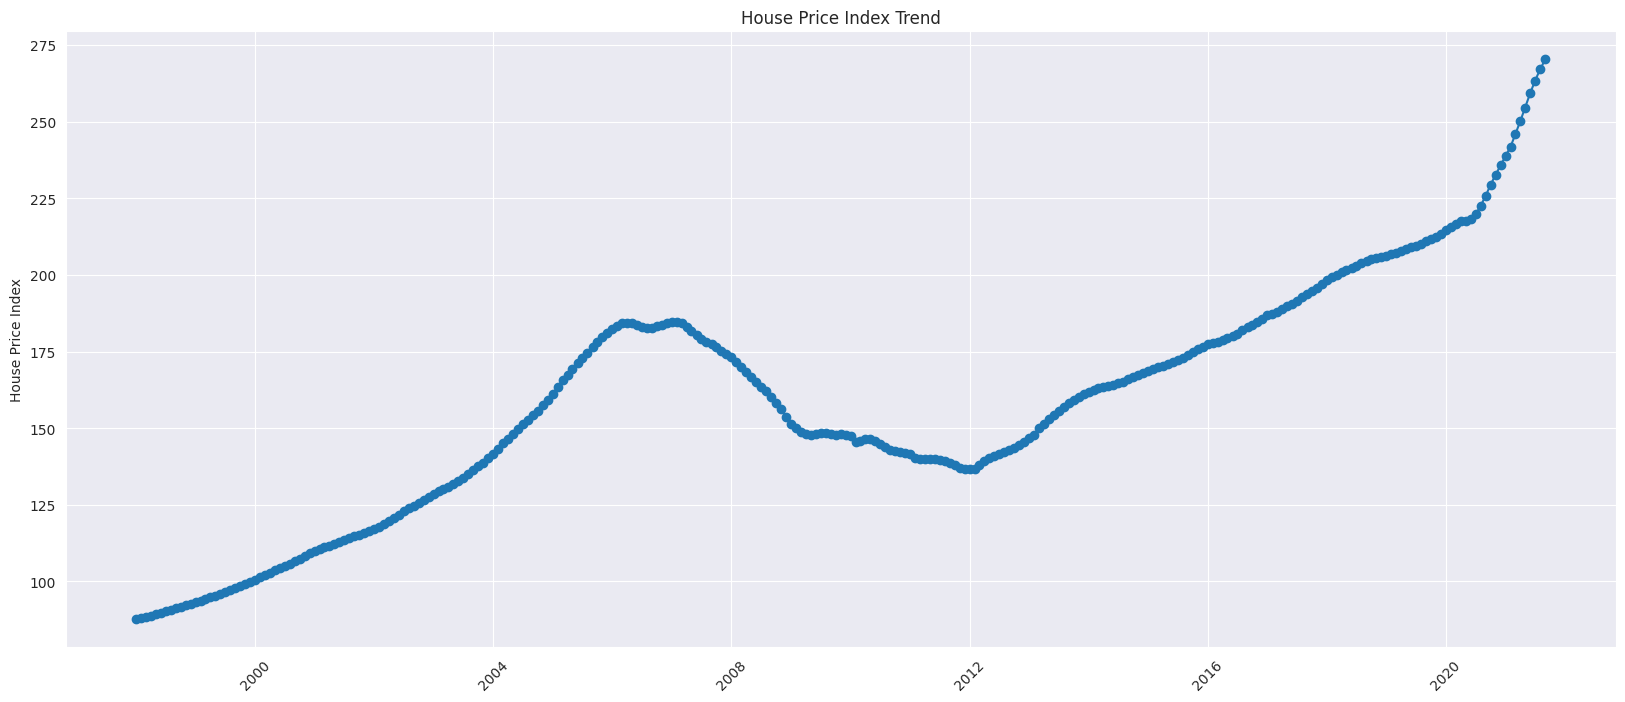

In [14]:
# Plotting the line chart
plt.figure(figsize=(20, 8))  # Set the figure size
plt.plot(macro.index, macro['house_price_index'], marker='o', linestyle='-')

# Adding labels and title
plt.ylabel('House Price Index')
plt.title('House Price Index Trend')

# Adding gridlines
plt.grid(True)

# Rotating x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()


### Observation:



*   The view is showing the trend of house price index on a monthly basis.
*   The overall trend shows increase in the house price index value.
*   But this view is not showing the numbers hence we are moving towards a combined yearly trend next.





### Yearly trend line of House Price Index across the US:

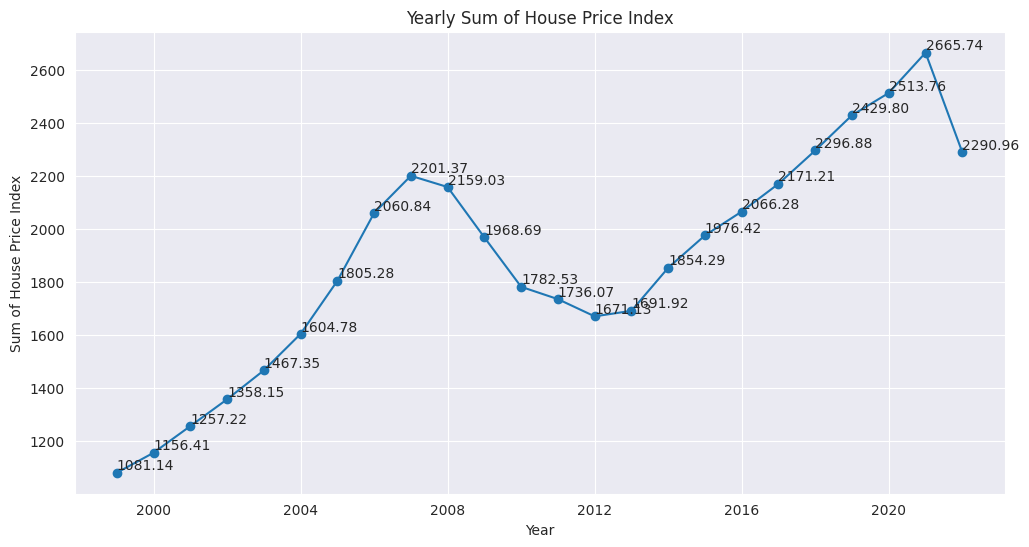

In [13]:
yearly_sum = macro['house_price_index'].resample('Y').sum()

# Plotting the line chart for yearly sums
plt.figure(figsize=(12, 6))  # Set the figure size
plt.plot(yearly_sum.index, yearly_sum, marker='o', linestyle='-')

# Adding data labels to the data points
for i, price_sum in enumerate(yearly_sum):
    plt.text(yearly_sum.index[i], price_sum, f'{price_sum:.2f}', ha='left', va='bottom')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Sum of House Price Index')
plt.title('Yearly Sum of House Price Index')

# Adding gridlines
plt.grid(True)

# Show the plot
plt.show()


### Observation:


*   As we can see from the plot, the overall total house price index has increased till 2022.
*   For 2023, we are not yet having the complete number as expected, hopefully the trend will only go up as per the previous years.



### Correlation matrix of the macroeconomic factors:

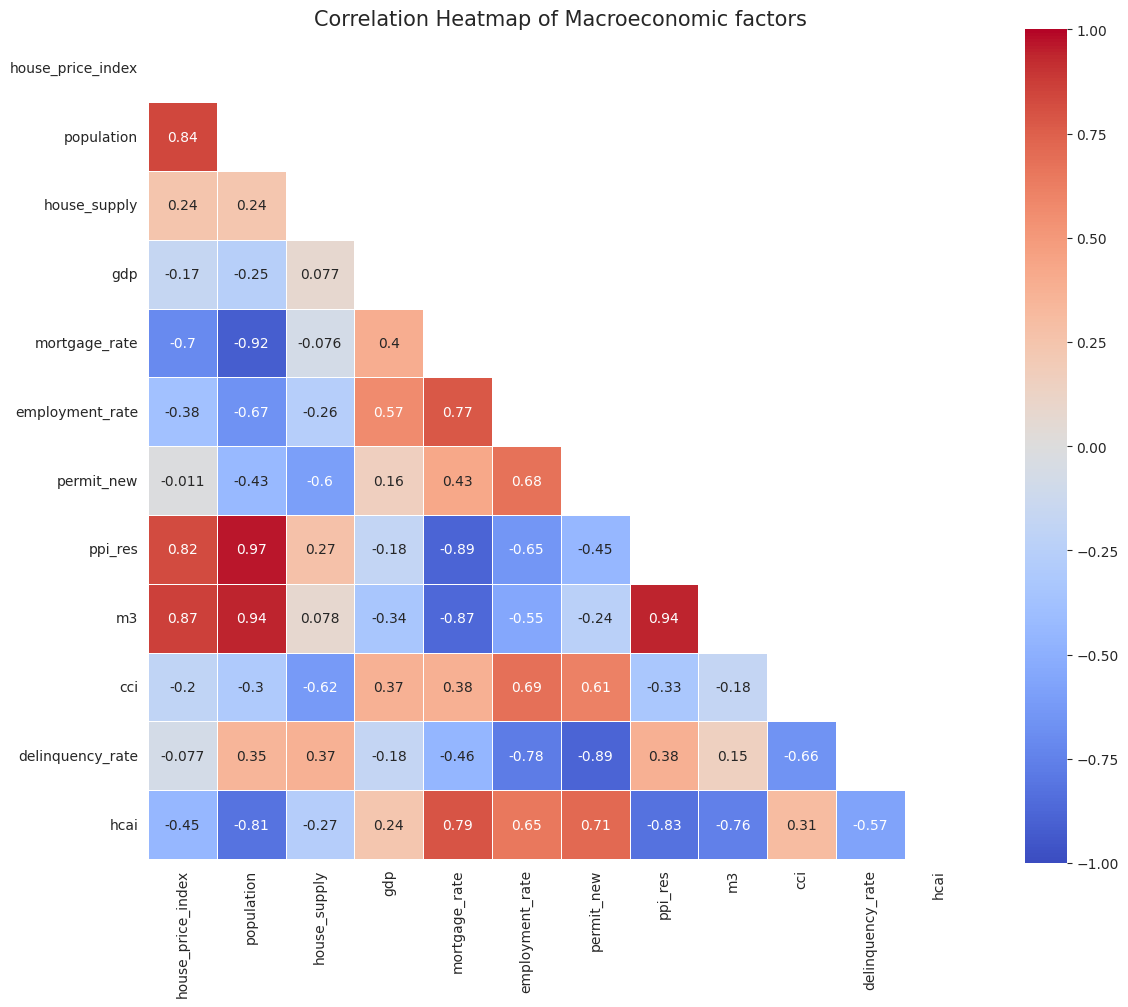

In [5]:
macrosd_corr = macro.corr()
mask = np.zeros_like(macrosd_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(macrosd_corr, mask=mask, vmax=1, vmin=-1, linewidths=.5, square=True, cmap='coolwarm', annot=True)
    plt.title('Correlation Heatmap of Macroeconomic factors', fontsize = 15)
    plt.yticks(rotation=0)
    plt.tight_layout()

#### *Observations:*
- HPI (house_price_index) has a very strong positive linear relationship with Population, Producer Price Index involved with Residential Construction (ppi_res) & m3
- It also has a strong negative linear relationship with mortgage_rate.
- But, we can note, that Population has even stronger positive relationship with ppi_res and m3, while a strong negative relationship with mortgage_rate.

# 2. Data Modelling

### Normalizing to scale the features (Feature Scaling)

In [15]:
macro_df = macro.copy().reset_index()
macro_df = macro_df.drop(columns=['Date'])

In [17]:
scaler = MinMaxScaler()
n_macro=pd.DataFrame(scaler.fit_transform(macro_df), columns=macro_df.columns, index=macro_df.index)
n_macro.head()

,house_price_index,population,house_supply,gdp,mortgage_rate,employment_rate,permit_new,ppi_res,m3,cci,delinquency_rate,hcai
0,0.000000,0.000000,0.078652,0.821908,0.739153,0.943701,0.595429,0.001452,0.000000,0.932625,0.076305,0.396848
1,0.002124,0.003659,0.067416,0.820545,0.747470,0.948666,0.648000,0.002905,0.001931,0.959385,0.076305,0.396848
2,0.004528,0.007682,0.089888,0.820034,0.762048,0.950251,0.624000,0.002905,0.003431,0.960628,0.076305,0.396848
3,0.006915,0.012172,0.078652,0.820924,0.764191,0.955233,0.590857,0.005810,0.004960,0.957114,0.063253,0.378574
4,0.009576,0.016785,0.067416,0.823797,0.764877,0.956024,0.594857,0.003631,0.006389,0.940880,0.063253,0.378574


### Splitting the dataset:

In [18]:
X_train, X_test, y_train, y_test = train_test_split(n_macro.drop(columns="house_price_index", axis=1), n_macro["house_price_index"], test_size= 0.30, random_state=42)

### Performing and evaluating various regression models:

### 1. Lasso Regression:

In [19]:
# define evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# defining the model
model1 = Lasso(alpha=1.0)
scores1 = cross_val_score(model1, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores1 = np.absolute(scores1)

print('Mean MAE: %.3f (%.3f)' % (np.mean(scores1), np.std(scores1)))

Mean MAE: 0.167 (0.027)


### 2. Ridge Regression:

In [20]:
model2 = Ridge(alpha=1.0)
scores2 = cross_val_score(model2, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores2 = np.absolute(scores2)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores2), np.std(scores2)))

Mean MAE: 0.024 (0.004)


### 3. Bayesian Ridge Regression:

In [ ]:
model3 = BayesianRidge()
scores3 = cross_val_score(model3, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores3 = np.absolute(scores3)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores3), np.std(scores3)))

Mean MAE: 0.019 (0.003)


### 4. Linear Regression Model:

In [ ]:
model4 = LinearRegression()
scores4 = cross_val_score(model4, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores4 = np.absolute(scores4)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores4), np.std(scores4)))

Mean MAE: 0.019 (0.003)


### 5. Elastic Net:

In [ ]:
model5 = ElasticNet()
scores5 = cross_val_score(model5, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores5 = np.absolute(scores5)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores5), np.std(scores5)))

Mean MAE: 0.167 (0.027)


Here, BayesianRidge & Linear Regression had the best score in terms of MAE (least MAE stands for more accuracy). Let's Chose BayesianRidge for further optimization.

### 3. Hyperparameter Selection for model optimization:

In [21]:
clf = GridSearchCV(BayesianRidge(),{
    'alpha_1':list(range(0,10,1)),
    'alpha_2':list(range(0,10,1)),
    'lambda_1':list(range(0,10,1)),
    'lambda_2':list(range(0,10,1))

}, cv=5, return_train_score=False )

clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=BayesianRidge(),
             param_grid={'alpha_1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'alpha_2': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'lambda_1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'lambda_2': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]})

In [22]:
param_df = pd.DataFrame(clf.cv_results_)
param_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha_1,param_alpha_2,param_lambda_1,param_lambda_2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.007529,0.006763,0.002663,0.000427,0,0,0,0,"{'alpha_1': 0, 'alpha_2': 0, 'lambda_1': 0, 'l...",0.968404,0.983701,0.985508,0.988016,0.989245,0.982975,0.007537,6040
1,0.003912,0.000101,0.002461,0.000315,0,0,0,1,"{'alpha_1': 0, 'alpha_2': 0, 'lambda_1': 0, 'l...",0.968477,0.983286,0.985306,0.987991,0.989304,0.982873,0.007495,6594
2,0.003816,0.000092,0.002365,0.000129,0,0,0,2,"{'alpha_1': 0, 'alpha_2': 0, 'lambda_1': 0, 'l...",0.968486,0.983227,0.985277,0.987988,0.989311,0.982858,0.007490,6806
3,0.003694,0.000031,0.002261,0.000080,0,0,0,3,"{'alpha_1': 0, 'alpha_2': 0, 'lambda_1': 0, 'l...",0.968489,0.983203,0.985266,0.987986,0.989314,0.982851,0.007488,6995
4,0.003792,0.000169,0.002424,0.000255,0,0,0,4,"{'alpha_1': 0, 'alpha_2': 0, 'lambda_1': 0, 'l...",0.968491,0.983190,0.985260,0.987985,0.989315,0.982848,0.007487,7167


### Let's get the test score...

In [23]:
max_test_score = np.max(param_df["mean_test_score"])
print(max_test_score)

0.9832190218864664


In [24]:
param_df[param_df['mean_test_score']==max_test_score]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha_1,param_alpha_2,param_lambda_1,param_lambda_2,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
806,0.002291,0.000026,0.001424,0.000006,0,8,0,6,"{'alpha_1': 0, 'alpha_2': 8, 'lambda_1': 0, 'l...",0.967912,0.985051,0.986235,0.988017,0.98888,0.983219,0.007769,1


In [25]:
print('''Hyper Parameters are:
            alpha_1: {}
            alpha_2: {}

            lambda_1: {}
            lambda_2: {}'''.format(param_df["param_alpha_1"][806], param_df["param_alpha_2"][806], param_df["param_lambda_1"][806], param_df["param_lambda_2"][806]))

Hyper Parameters are:
            alpha_1: 0
            alpha_2: 8
            
            lambda_1: 0
            lambda_2: 6


### 4. Model Fitting:

In [26]:
# Model Defining and Fitting
model_br= BayesianRidge(alpha_1=0, alpha_2=1, lambda_1=9, lambda_2=9)
fit_data = model_br.fit(X_train, y_train)

### 5. Model Performance and Prediction:

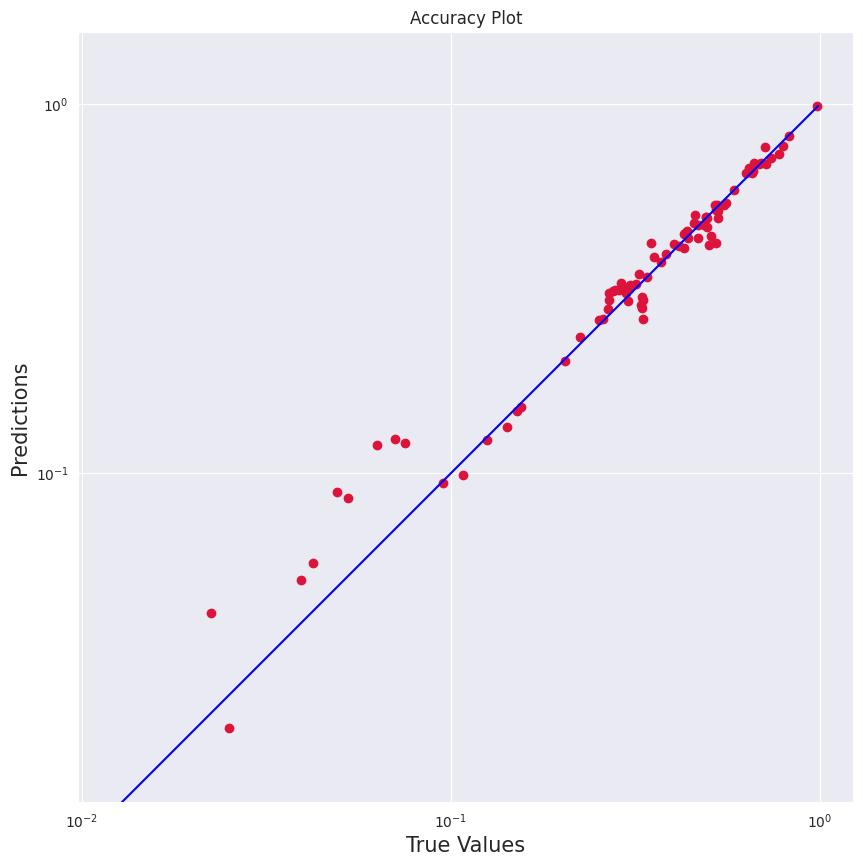

In [27]:
# Prediction

prediction = fit_data.predict(X_test)

# Plotting both the curves simultaneously
plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction), max(y_test))
p2 = min(min(prediction), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.title("Accuracy Plot")
plt.axis('equal')
plt.show()

The above linear relationship and the data points show us the accuracy of the model and how good our regression model is performing or can perform with new data.

### Bias-Variance Check:

In [28]:
from mlxtend.evaluate import bias_variance_decomp
X_tr = X_train.to_numpy(dtype ='float32')
X_tst = X_test.to_numpy(dtype ='float32')
y_tr = y_train.to_numpy(dtype ='float32')
y_tst = y_test.to_numpy(dtype ='float32')

mse, bias, variance = bias_variance_decomp(model_br, X_tr, y_tr, X_tst, y_tst,
                                           loss='mse', num_rounds=200, random_seed=123)
print("Average Bias : ", bias)
print("Average Variance : ", variance)

Average Bias :  0.0009344158558913755
Average Variance :  4.204274840410594e-05


### Let's check the error metrics too...

In [29]:
rmse=np.sqrt(mean_squared_error(y_test, prediction))
print('RMSE: ', rmse)
r2 = r2_score(y_test, prediction)
print('R squared: ', r2)

RMSE:  0.030622590435954708
R squared:  0.9799314600892053


### OLS using statsmodel:

In [30]:
result = sm.OLS(y_train, X_train).fit()
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:      house_price_index   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              5856.
Date:                Fri, 03 Nov 2023   Prob (F-statistic):                   6.55e-232
Time:                        20:14:25   Log-Likelihood:                          459.94
No. Observations:                 199   AIC:                                     -897.9
Df Residuals:                     188   BIC:                                     -861.7
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

### 6. Insights and the Final Verdict:

- ```Here, the model shows that 'cci' aka Consumer Confidence Index has no relationship with the target house_price_index since it fails to rejects the null hypothesis (there's no relationship) i.e., p values > 0.05. Alternative hypothesis being 'some relationship exists' is true for the rest of the features except CCI```

- This model also shows that the 99.7% (r squares = 0.997) of the variability of house price index can be explained by it's independent features.



### THANK YOU!!